In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space
import pylops
from scipy import misc
import pyproximal

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
})


### Załózmy, ze mamy wektor $y = [0,7]$.

In [40]:
# przykładowy wektor obserwacji y
y= np.array([0.7])
print("y:" + str(y))

y:[0.7]


### Macierz X jest macierzą losową o elementach losowanych z rozkładu jednostajnego $[0,1]$.

In [2]:
# Tworzenie macierzy wymiaru 1x2
np.random.seed()
n, d = 1, 2
X = np.random.rand(n, d) # Macierz X o elementach losowych z przedziału [0, 1)
print("Macierz X:" + str(X)) 
# Wyznaczanie jądra macierzy X
ker_X = null_space(X)
print("Jądro macierzy X:")
print(ker_X)

Macierz X:[[0.79711749 0.27431316]]
Jądro macierzy X:
[[-0.32540228]
 [ 0.94557567]]


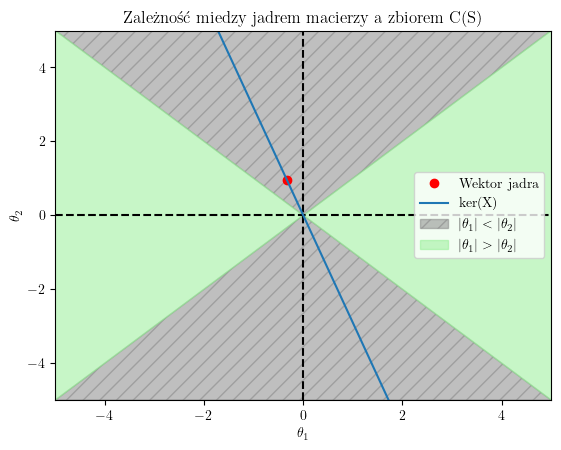

In [4]:
# Wybór zbioru S oznaczającego element oryginalnego wektora regresji (wiedza a priori)
# Zakladamy ze znamy S dla przykladu, zeby pokazac na przykladzie ze jak przeciecie to wektor zerowy to l_1 zadziala,
S = 2

plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# Tworzenie t dla przedziału (-3, 3) do stworzenia linii prostej
t = np.linspace(-7, 7, 800)
plt.plot(ker_X[0,0], ker_X[1,0], 'ro', label='Wektor jadra')
plt.plot(t * ker_X[0,0], t * ker_X[1,0], label='ker(X)')


# Tworzenie zbiorów C(S) dla S = 1 i S = 0 (wiemy ze poszukiwany wektor regresji bedzie w zakreslonym zbiorze)
y1 = np.abs(t)
y2 = -np.abs(t)

# Zbiór C(S) dla S = 2 (ciemno szara strefa)
hatch = '//' if S == 2 else ''
plt.fill_between(t, y1, 5, color='gray', alpha=0.5,hatch=hatch, label=r'$|\theta_1| < |\theta_2|$')
plt.fill_between(t, y2, -5, color='gray', alpha=0.5, hatch=hatch,)

# Zbiór C(S) dla S = 1 (jasno zielona strefa)
hatch = '//' if S == 1 else ''
plt.fill_between(t, y1, y2, color='lightgreen', alpha=0.5, hatch=hatch, label=r'$|\theta_1| > |\theta_2|$')


plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Zależność miedzy jadrem macierzy a zbiorem C(S)')
plt.legend()

# # Show the plot
plt.show()

### Jeśli przecięcie jądra macierzy (prostej) ze zbiorem C(S) (zakreślonym obszarem) zawiera jedynie wektor zerowy, to za pomocą programu (6) otrzymamy poszukiwany wektor — znajdujący się w tym obszarze, co wiemy dzięki wiedzy a priori. Natomiast jeśli przecięcie zawiera również inne wektory, program (6) zwróci rozwiązanie spoza zakreślonego obszaru.

### Mamy układ i szukamy thety, inicjalizujemy jako wektor $[0,0]$.

In [5]:
# wektor regresji theta, który chcemy znaleźć, inicializowany jako wektor zerowy
theta = np.zeros(d)
print("theta:" + str(theta)) 
# przykładowy wektor obserwacji y
y= np.array([0.7])
print("y:" + str(y))
print("X:" + str(X))

theta:[0. 0.]
y:[0.7]
X:[[0.79711749 0.27431316]]


### Są opracowane metody (biblioteki) ktore optymalizują ten proces, przykład ponizej:

In [6]:
# operator liniowy, który reprezentuje model regresji liniowej y = X*theta
X_op = pylops.MatrixMult(X)
# nie zapisujemy jądra operatora w pamięci, zatem macierzy X (pokazuje to tez ze nie trzeba tego robic ogolnie przy odzyskiwaniu wektora regresji)
X_op.explicit = False 


### Tutaj definicja programu (6) z pracy

In [7]:
# Definicja przestrzeni afinicznej (warunek Xθ = y)
przestrzen_decyzyjna = pyproximal.AffineSet(X_op, y, niter=100)

In [8]:
funkcja_celu = pyproximal.L1()


In [9]:
print("Macierz X:")
print(przestrzen_decyzyjna.Op)  # Macierz X

print("Wektor y:")
print(przestrzen_decyzyjna.b)  # Wektor y

theta_test = np.random.randn(X.shape[1])  # Losowy wektor theta
projected_theta = przestrzen_decyzyjna.prox(theta_test, 1.0)  # Projekcja,  1.0 to parametr odległości (tau), ale w AffineSet nie wpływa na wynik – jest wymagany tylko składniowo.

print("Wektor theta przed projekcją:", theta_test)
print("Wektor theta po projekcji:", projected_theta)

print("y = X*theta:")
print(X @ theta_test)
print("y = X*theta_proj:")
print(X @ projected_theta)  # Wartość y dla wektora theta po projekcji powinna być



Macierz X:
<1x2 MatrixMult with dtype=float64>
Wektor y:
[0.7]
Wektor theta przed projekcją: [-0.55973164  0.17038895]
Wektor theta po projekcji: [0.67348278 0.59477676]
y = X*theta:
[-0.39943195]
y = X*theta_proj:
[0.7]


In [10]:
#	ADMM() (Alternating Direction Method of Multipliers) znajduje optymalne  \theta .
theta_poczatkowa = pyproximal.optimization.primal.ADMM(przestrzen_decyzyjna, funkcja_celu, np.zeros_like(theta),
                                                 0.1, niter=5, show=False)[0]

In [11]:
theta_poczatkowa

array([ 0.88608121, -0.02300593])

In [12]:
theta_koncowa = pyproximal.optimization.primal.ADMM(przestrzen_decyzyjna, funkcja_celu, np.zeros_like(theta),
                                           0.1, niter=100, show=False)[0]

In [13]:
theta_koncowa


array([0.87816414, 0.        ])

In [14]:
from scipy.linalg import lstsq

def solve_l0_given_S(X, y, S):
    """
    Znajduje rozwiązanie równania y = X * theta przy znanym zbiorze S,
    który określa, który indeks wektora theta może być niezerowy.

    Parametry:
    X (numpy.ndarray): Macierz wejściowa (m x n).
    y (numpy.ndarray): Wektor wynikowy (m,).
    S (int): Indeks (1 lub 2) określający, który element theta może być niezerowy.

    Zwraca:
    numpy.ndarray: Wektor theta z niezerowym elementem tylko na indeksie S-1.
    """
    m, n = X.shape
    theta = np.zeros(n)  # Inicjalizacja wektora theta jako wektora zerowego

    if S < 1 or S > n:
        raise ValueError("Wartość S musi być 1 lub 2")

    # Wybieramy tylko odpowiednią kolumnę macierzy X
    X_subset = X[:, [S - 1]]

    # Rozwiązujemy układ równań dla tej jednej kolumny
    theta_subset, residuals, rank, _ = lstsq(X_subset, y)

    # Umieszczamy wartość w odpowiednim miejscu wektora theta
    theta[S - 1] = theta_subset[0]

    return theta


# Test dla S=1
S = 1
theta_opt = solve_l0_given_S(X, y, S)
print(f"Optymalne theta dla S={S}:", theta_opt)

# Test dla S=2
S = 2
theta_opt = solve_l0_given_S(X, y, S)
print(f"Optymalne theta dla S={S}:", theta_opt)

Optymalne theta dla S=1: [0.87816414 0.        ]
Optymalne theta dla S=2: [0.         2.55182799]


/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_38144/3790222788.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(theta_koncowa[0], theta_koncowa[1], 'ro', color = 'orange', label=r'Rozwiazanie programu $\theta$')


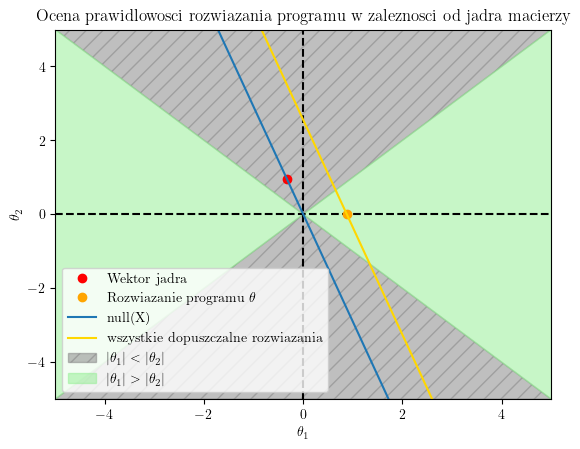

In [15]:
#Pokazanie jak wyglada rozwiazanie programu

plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.plot(ker_X[0,0], ker_X[1,0], 'ro', label='Wektor jadra')
plt.plot(theta_koncowa[0], theta_koncowa[1], 'ro', color = 'orange', label=r'Rozwiazanie programu $\theta$')

plt.plot(t * ker_X[0,0], t * ker_X[1,0], label='null(X)')
plt.plot(t * ker_X[0,0] + theta_koncowa[0], t * ker_X[1,0] + theta_koncowa[1], label='wszystkie dopuszczalne rozwiazania', color='gold')

y1 = np.abs(t)
y2 = -np.abs(t)

hatch = '//' if S == 2 else ''
plt.fill_between(t, y1, 5, color='gray', alpha=0.5,hatch=hatch, label=r'$|\theta_1| < |\theta_2|$')
plt.fill_between(t, y2, -5, color='gray', alpha=0.5, hatch=hatch,)

hatch = '//' if S == 1 else ''
plt.fill_between(t, y1, y2, color='lightgreen', alpha=0.5, hatch=hatch, label=r'$|\theta_1| > |\theta_2|$')

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Ocena prawidlowosci rozwiazania programu w zaleznosci od jadra macierzy')
plt.legend()

plt.show()

In [16]:
t * ker_X[0,0] + theta_koncowa[0], t * ker_X[1,0] + theta_koncowa[1]

(array([ 3.15598011e+00,  3.15027844e+00,  3.14457677e+00,  3.13887511e+00,
         3.13317344e+00,  3.12747177e+00,  3.12177011e+00,  3.11606844e+00,
         3.11036677e+00,  3.10466511e+00,  3.09896344e+00,  3.09326177e+00,
         3.08756010e+00,  3.08185844e+00,  3.07615677e+00,  3.07045510e+00,
         3.06475344e+00,  3.05905177e+00,  3.05335010e+00,  3.04764844e+00,
         3.04194677e+00,  3.03624510e+00,  3.03054343e+00,  3.02484177e+00,
         3.01914010e+00,  3.01343843e+00,  3.00773677e+00,  3.00203510e+00,
         2.99633343e+00,  2.99063177e+00,  2.98493010e+00,  2.97922843e+00,
         2.97352676e+00,  2.96782510e+00,  2.96212343e+00,  2.95642176e+00,
         2.95072010e+00,  2.94501843e+00,  2.93931676e+00,  2.93361510e+00,
         2.92791343e+00,  2.92221176e+00,  2.91651009e+00,  2.91080843e+00,
         2.90510676e+00,  2.89940509e+00,  2.89370343e+00,  2.88800176e+00,
         2.88230009e+00,  2.87659843e+00,  2.87089676e+00,  2.86519509e+00,
         2.8

In [17]:
t_x0 = -theta_koncowa[0] / ker_X[0, 0]

# Obliczamy y dla tego t
y_x0 = t_x0 * ker_X[1, 0] + theta_koncowa[1]

In [18]:
t_x0

np.float64(2.6987030895169175)

In [19]:
y_x0

np.float64(2.551827993146763)